In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from src.data_augmentation import *
from src.folder_preparation import *
import seaborn as sns
from tensorflow.keras import layers
import sklearn.metrics as metrics

### resize and move data into folders with train and validation subdirectories
#### <font color='red'> only run once!</font>

In [6]:
target_dir = Path('../simplifed-data-only-oranges')
resize_and_move_images_to_train_val_folders(target_dir=target_dir,
                                           split_ratio=0.1,
                                           image_format='.png',
                                           target_size=255)

### create dataset

In [7]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [8]:
batch_size = 4
img_height = 255
img_width = 192

In [18]:
train_dir = Path('./split_simplifed-data-only-oranges/train')
val_dir = Path('./split_simplifed-data-only-oranges/validation')

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size=batch_size
)

Found 964 files belonging to 10 classes.


In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 112 files belonging to 10 classes.


### visualize the data

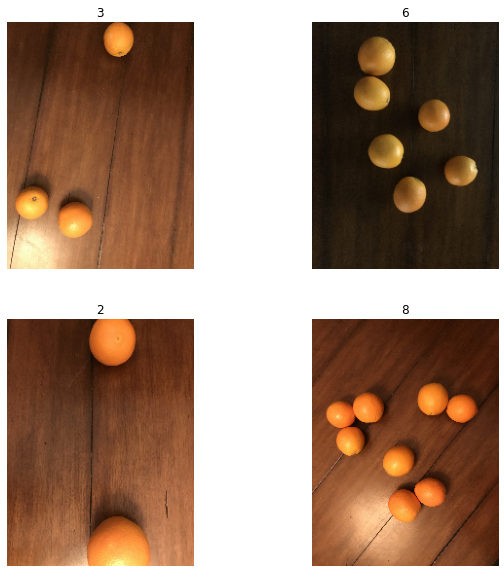

In [21]:
class_names = train_ds.class_names
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### standardize data

In [22]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [23]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x),y))

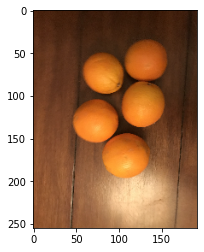

In [24]:
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
plt.imshow(first_image)

### configure dataset for performance

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [26]:
train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### train a model

In [27]:
num_classes = 10
model = tf.keras.Sequential([
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [29]:
# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

In [30]:
normalized_train_ds

<MapDataset shapes: ((None, 255, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [31]:
print('{} train and {} val before ignoring errors'.format(len(train_ds),
                                                          len(val_ds)))
train_ds = train_ds.apply(tf.data.experimental.ignore_errors())
val_ds = val_ds.apply(tf.data.experimental.ignore_errors())
print('{} train and {} val after ignoring errors'.format(len(train_ds)
                                                          ,len(val_ds)))

241 train and 28 val before ignoring errors
241 train and 28 val after ignoring errors


In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
241/241 [==============================] - 19s 78ms/step - loss: 0.5382 - accuracy: 0.8091 - val_loss: 2.5339 - val_accuracy: 0.4018
Epoch 2/20
241/241 [==============================] - 20s 83ms/step - loss: 0.2536 - accuracy: 0.9139 - val_loss: 3.7533 - val_accuracy: 0.3482
Epoch 3/20
241/241 [==============================] - 19s 78ms/step - loss: 0.1827 - accuracy: 0.9471 - val_loss: 4.6660 - val_accuracy: 0.3482
Epoch 4/20
241/241 [==============================] - 22s 90ms/step - loss: 0.0858 - accuracy: 0.9772 - val_loss: 4.5731 - val_accuracy: 0.4018
Epoch 5/20
241/241 [==============================] - 19s 80ms/step - loss: 0.0721 - accuracy: 0.9824 - val_loss: 4.2196 - val_accuracy: 0.3929
Epoch 6/20
241/241 [==============================] - 19s 80ms/step - loss: 0.0383 - accuracy: 0.9907 - val_loss: 4.8661 - val_accuracy: 0.3839
Epoch 7/20
241/241 [==============================] - 19s 79ms/step - loss: 0.0385 - accuracy: 0.9938 - val_loss: 4.5022 - val_accuracy:

In [ ]:
stop here

### model evaluation

In [34]:
predictions = model.predict_generator(val_ds)

Instructions for updating:
Please use Model.predict, which supports generators.


In [35]:
predicted_classes = np.argmax(predictions, axis=1)

In [36]:
predicted_classes

array([9, 3, 1, 4, 4, 5, 4, 8, 6, 1, 2, 5, 9, 5, 2, 0, 5, 4, 5, 4, 8, 7,
       4, 5, 5, 0, 4, 2, 9, 6, 5, 2, 1, 1, 8, 3, 4, 3, 2, 3, 1, 1, 8, 7,
       8, 9, 1, 6, 9, 2, 6, 7, 4, 4, 3, 9, 9, 9, 6, 7, 6, 5, 1, 3, 1, 9,
       9, 2, 7, 2, 1, 9, 6, 0, 6, 2, 1, 8, 9, 8, 9, 0, 2, 5, 1, 4, 1, 6,
       2, 9, 5, 6, 6, 6, 6, 7, 1, 8, 6, 8, 4, 9, 2, 6, 4, 9, 4, 6, 2, 4,
       3, 5])

In [37]:
labels = np.array([x[1].numpy() for x in list(val_ds)])

In [38]:
ground_truth = np.array(list(np.concatenate(labels, axis=0 )))

In [39]:
confusion_matrix = metrics.confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)  # shape=(12, 12)

In [40]:
cm_labels = list(np.sort(list(map(int,class_names))))

In [41]:
import pandas as pd

In [42]:
df_cm = pd.DataFrame(confusion_matrix,columns=cm_labels,index = cm_labels)

Text(0.5, 1.0, 'Confusion matrix')

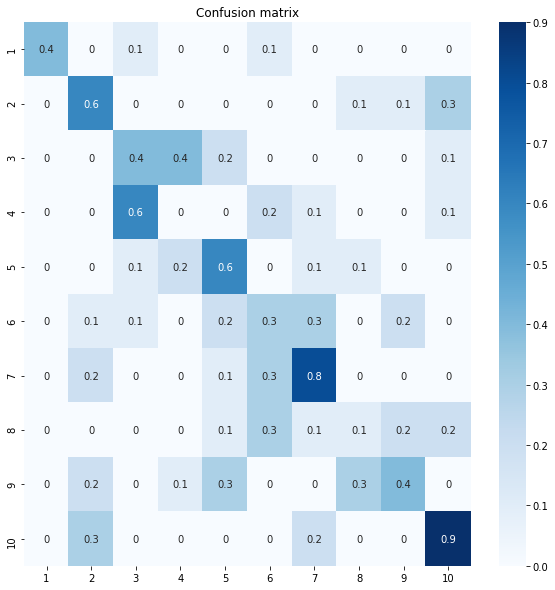

In [43]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cm/len(df_cm),
           cmap='Blues',
           annot=True)
plt.title('Confusion matrix')

### visualizing training history

In [44]:
history.history

{'loss': [0.5381982922554016,
  0.2536160349845886,
  0.1826552152633667,
  0.08583670854568481,
  0.07205601781606674,
  0.03829338401556015,
  0.03850709646940231,
  0.01713794469833374,
  0.001215906348079443,
  0.0001830191322369501,
  0.00012922230234835297,
  9.785468864720315e-05,
  7.649067265447229e-05,
  6.115553696872666e-05,
  4.970790178049356e-05,
  4.094247196917422e-05,
  3.403337177587673e-05,
  2.8492542696767487e-05,
  2.4022490833885968e-05,
  2.0380361092975363e-05],
 'accuracy': [0.8091286420822144,
  0.9139004349708557,
  0.9470954537391663,
  0.9771783947944641,
  0.9823651313781738,
  0.9906638860702515,
  0.9937759041786194,
  0.9989626407623291,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [2.5339300632476807,
  3.7532660961151123,
  4.666025638580322,
  4.573070526123047,
  4.219604969024658,
  4.866146087646484,
  4.502240180969238,
  5.046061992645264,
  5.672667503356934,
  5.781213283538818,
  5.894692

In [49]:
epochs = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


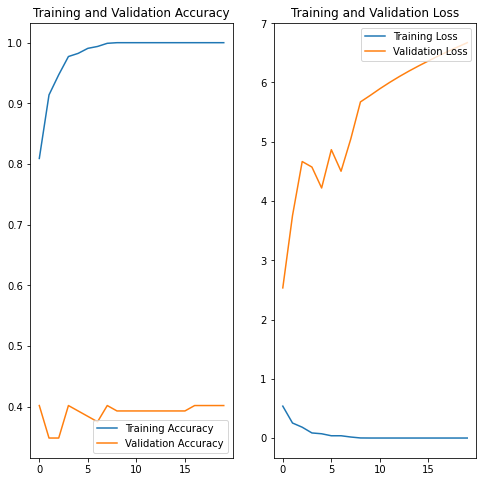

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### visualize filters

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 95, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 22, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 21120)             0

In [54]:
for layer in model.layers:
    print(layer.name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dense_1


In [57]:
layer = model.layers[2]
print(layer.name)

conv2d_1


In [58]:
filters,biases = layer.get_weights()
print(layer.name,filters.shape)

conv2d_1 (3, 3, 32, 32)


In [ ]:
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

### visualize featuremaps